In [77]:
# -*- coding: utf-8 -*-
import os
import math
import time
import random

import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from datetime import datetime
from scipy.special import logsumexp



## Algorithm

![xx](figure/algorithm.png)

In [78]:
# set a seed so that the results are reproducible
def set_random_seeds(seed_value):

    np.random.seed(seed_value)
    random.seed(seed_value)

## Model parameters

In [79]:
set_random_seeds(0)
method = 'DR Non' # method = 'DR Non', 'DR bisection', 'DR grid_search', 'DR NM'

n_data = 10
num_simulation = 10
max_steps = 600
num_trajs = 30

obs_cost = 1e3
dist_weight = 0.01

gamma = [300]
T = 10.0
dt = 0.1
theta = 0.01
goal_tolerance = 0.1



x_init = np.array([-3.0, 3.0, 0, 0])
x_goal = np.array([0,0])
x_hists = np.zeros((num_simulation, max_steps+1, 2))*np.nan

success_time = []
success_index = []
fail_index = []

## Obstacle Design

In [80]:
class Obstacle:
    def is_point_inside(self, point):
        """
        Check if a point is inside the obstacle.

        Parameters:
        point : The point to check.

        Returns:
        True if the point is inside the obstacle, False otherwise.
        """
        raise NotImplementedError("Subclasses should implement this method!")
    
class CircleObstacle(Obstacle):
    def __init__(self, center, radius):
        self.center = np.array(center)
        self.radius = radius

    def is_point_inside(self, point):
        return np.linalg.norm(point - self.center) <= self.radius


class RectangleObstacle(Obstacle):
    def __init__(self, lower_left_corner, width, height):
        self.lower_left_corner = np.array(lower_left_corner)
        self.upper_right_corner = self.lower_left_corner + np.array([width, height])

    def is_point_inside(self, point):
        return (self.lower_left_corner <= point).all() and (point <= self.upper_right_corner).all()

def check_hit_obstacle(x, obstacles):
    for obstacle in obstacles:
        if obstacle.is_point_inside(x[:2]):
            return True
    return False

obstacles = [
    CircleObstacle(center=[-2.5, 0.0], radius=2.0),
    # RectangleObstacle(lower_left_corner=[1.5, 1.5], width=1.0, height=1.0)
]

#obstacle_positions = np.array([[-2.5, 0.0]])
#obstacle_radius = np.array([2.0])

obstacle_positions = obstacles[0].center

obstacle_radius = obstacles[0].radius

## Dynamics
We consider a continuous-time and continuous-space stochastic process $\bm x(t)\in\mathbb{R}^{n}$ satisfying a control affine dynamic system, as follows:  

$$\begin{equation}
    d\bm x(t) = f\left(\bm x(t),t\right)dt + \bm G\left(\bm x(t),t\right)
    \bm u(\bm x(t),t)dt +  \bm \Sigma(\bm x(t), t) d\bm \xi(t) .
\end{equation}$$

Here, $f\left(\bm x(t),t\right)\in \mathbb{R}^n$ is a nonlinear passive dynamic, $\bm u(\bm x(t),t)\in \mathbb{R}^{p}$ is a control input, a control transition matrix $\bm G(\bm x(t),t)\in\mathbb{R}^{n\times p}$ is a full rank matrix-valued function with $n\geq p$. In addition, $\bm \xi(t)\in\mathbb{R}^{k}$ is a diffusion process and $\Sigma(\bm x(t), t)\in\mathbb{R}^{n\times k}$ is a diffusion matrix that maps the noise to the state. We consider $\bm \xi(t)\in\mathbb{R}^{k}$ as a drifted diffusion process which is defined as $d\bm \xi(t) = \bm \mu\left(\bm x(t),t\right)dt + d\bm w(t)$.  $d\bm w(t)$ is the increment of a standard Wiener process and the drift term $\bm \mu(\bm x, t)\in\mathbb{R}^{k}$ is the deterministic component that influences the expected rate of change of the process. Hence, $\bm \mu(\bm x, t)$  can be interpreted as a systemic bias in the evolution of the stochastic process over time.

In [81]:
F = np.array([[1, 0, dt, 0],
              [0, 1, 0, dt],
              [0, 0, 1, 0],
              [0, 0, 0, 1]])
        
G= np.array([[(dt**2)/2, 0],
             [0, (dt**2)/2],
             [dt, 0],
             [0, dt]])

true_mu = np.array([0.003, 0.003])
Sigma = np.array([[0.01, 0.0], 
                  [0.0, 0.01]])

## Sampling

In [82]:
def estimate_mu(N):
    return np.mean(np.random.multivariate_normal(true_mu, Sigma, N), axis=0)

def sample_noise(Sigma, T=10.0, dt=0.5, num_trajs=500, n=2) :
    if len(Sigma) != n :
        n = len(Sigma)
    time_steps = math.floor(T/dt)
    estimated_mu = estimate_mu(num_trajs)
    noise_samples = np.random.multivariate_normal(estimated_mu, Sigma , [num_trajs,time_steps])
    return noise_samples

# Rollout

In [83]:
def stage_cost(dist2, dist_weight = 10) :
    return dist_weight*dist2

def term_cost(dist2, goal_reached) :
    return (1 - float(goal_reached)) * dist2

def compute_next_state(x_curr, noise, dt):
    return F @ x_curr + G @ noise 



def rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost=10, num_trajs=500, goal_tolerance=0.1):
    costs = np.zeros(num_trajs)
    # time_steps = len(u_curr) # Haven't defined u_curr yet
    time_steps = int(T//dt)
    goal_reached = False
    goal_tolerance_sq = goal_tolerance ** 2
    dist_to_goal2 = 1e9
    
    x_vis = np.zeros( (20, time_steps, 2) )*np.nan
    n = len(x0)
    
    for k in range(num_trajs):
        x_curr = np.zeros(n)
        for i in range(n) :
            x_curr[i] = x0[i]
        if k < 20 :
            x_vis[k, 0, :] = x_curr[:2]
            
        for t in range(time_steps):
            
            # Compute next state
            x_curr = compute_next_state(x_curr, noise_samples[k, t, :], dt)
            
            if k < 20:
                x_vis[k, t, :] = x_curr[:2]
                
            dist_to_goal2 = (x_goal[0]-x_curr[0])**2 + (x_goal[1]-x_curr[1])**2
            
            # Calculate stage cost
            costs[k] += stage_cost(dist_to_goal2, dist_weight)
            
            if dist_to_goal2 < 0.01 :
                break
            
            # Calculate obstacle cost
            costs[k] += compute_obstacle_cost(x_curr, obs_pos, obs_r, obs_cost)
                
            # Calculate boundary penalty
            costs[k] += compute_boundary_penalty(x_curr, obs_cost)
                
            if dist_to_goal2 <= goal_tolerance_sq:
                goal_reached = True
                break
            
            # Terminal cost
            costs[k] += term_cost(dist_to_goal2, goal_reached) 
    return costs, x_vis

## Optimization

In [84]:
def update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2) :
    # 100 
    costs = np.exp( - (costs) / lambda_neut ) 
    sum_costs = np.sum(costs)    
    
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))
    for t in range(time_steps) :
        for k in range(len(costs)) :
            u_curr[t,:] += (costs[k] / sum_costs ) * noise_samples[k,t,:] 
    return u_curr

def update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :    
    num_trajs = len(noise_samples)
    for gamma in gammas :
        lambda_l = 1e-3; lambda_r = 1e3
        # theta_l = -1e10; theta_r = 1e10 
        k = 0
        K = 300        
        while k < K :
            lambda_1 = lambda_l + (lambda_r - lambda_l) / 3
            lambda_2 = lambda_l + 2 * (lambda_r - lambda_l) / 3
            
            opt_cost_1 = gamma / lambda_1 - lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) )
            opt_cost_2 = gamma / lambda_2 - lambda_2 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_2 )  ) )
            # print(- lambda_1 * np.log( 1/num_trajs * np.sum( np.exp( -costs / lambda_1)  ) ))
            
            if opt_cost_1 > opt_cost_2:
                lambda_l = lambda_1
            elif opt_cost_1 < opt_cost_2 :
                lambda_r = lambda_2
            
            if lambda_r - lambda_l <= 1e-3:
                break
            
            optimal_cost = min(opt_cost_1, opt_cost_2)
            k += 1

    # if init_report == 0 :
    if init_report % 10 == 0 :
        print(lambda_r)
    
    # min_cost = np.min(costs)
    # costs = np.exp( - (costs - min_cost) / lambda_r ) 
    costs = np.exp( - (costs ) / lambda_r ) 
    sum_costs = np.sum(costs)
    
    time_steps = math.floor(T/dt)
    u_curr = np.zeros((time_steps,n))    
    for k in range(len(costs)) :
        u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 
    
    return u_curr

def update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2) :
    num_trajs = len(noise_samples)
    lambda_grid = np.linspace(1e-3, 1e3, num_trajs)  # grid of lambda values
    for gamma in gammas :
        opt_costs = []
        for lambda_ in lambda_grid:
            opt_cost = gamma / lambda_ - lambda_ * np.log(1/num_trajs * np.sum(np.exp(-costs / lambda_)))
            opt_costs.append(opt_cost)
        lambda_r = lambda_grid[np.argmin(opt_costs)]  # Select the lambda that gives the minimum cost

        costs = np.exp(-costs / lambda_r) 
        sum_costs = np.sum(costs)

        time_steps = math.floor(T/dt)
        u_curr = np.zeros((time_steps,n))    
        for k in range(len(costs)) :
            u_curr[0,:] += (costs[k] / sum_costs ) * noise_samples[k,0,:] 

    return u_curr

def update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2):
    num_trajs = len(noise_samples)

    # Define the cost function wrapper
    def opt_cost_func(lambda_, gamma, costs, num_trajs):
        #denominator = 1 / num_trajs * np.sum(np.exp(-costs / lambda_))
        log_denominator = logsumexp(-costs / lambda_) - np.log(num_trajs)
        denominator = np.exp(log_denominator)
        if denominator == 0:
            return np.inf  # Return a large value to indicate failure
        return gamma / lambda_ - lambda_ * np.log(denominator)

    for gamma in gammas:
        # Alternatively, use the Nelder-Mead method.  'Powell', 'CG', 'BFGS', 'Newton-CG', 'L-BFGS-B', 'TNC', 'COBYLA', 'SLSQP', 'trust-constr', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov'
        result = minimize(opt_cost_func, x0=1.0, args=(gamma, costs, num_trajs), method='Powell', options={'maxiter': 10000})

        if result.success:
            lambda_r = result.x[0]
        else:
            print("Optimization failed for gamma =", gamma)
            continue  # Move on to the next gamma if optimization failed

        costs = np.exp(-costs / lambda_r)
        sum_costs = np.sum(costs)

        time_steps = math.floor(T / dt)
        u_curr = np.zeros((time_steps, n))
        for k in range(len(costs)):
            u_curr[0, :] += (costs[k] / sum_costs) * noise_samples[k, 0, :]

    return u_curr


## Path Integral

In [85]:
def path_integral(Sigma, x0, x_goal, u_curr, dist_weight, obs_cost, obs_pos, obs_r, T, dt, theta, num_trajs, init_report, gammas, method):
    
    noise_samples = sample_noise(Sigma, T, dt, num_trajs, n=2)
    costs, x_vis = rollout(x0, x_goal, u_curr, obs_pos, obs_r, T, dt, theta, noise_samples, dist_weight, Sigma, obs_cost, num_trajs, goal_tolerance=0.1)   
    
    if method == 'DR Non':
        u_curr = update_useq_risk_neutral(costs, u_curr, noise_samples, T, dt, lambda_neut=100, n=2)
    elif method == 'DR bisection':
        u_curr = update_useq_bisection(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR grid_search':
        u_curr = update_useq_grid_search(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    elif method == 'DR NM':
        u_curr = update_useq_NM(costs, u_curr, noise_samples, gammas, T, dt, init_report, n=2)
    else:
        raise ValueError(f"Unknown method: {method}")
    
    return u_curr, x_vis


## Visualization

In [86]:
def plot_initial_and_goal_states(ax, x0, x_goal):
    ax.plot([x0[0]], [x0[1]], '8', markersize=20, markerfacecolor='lime', label='Initial State', markeredgecolor='k', zorder=6)
    ax.plot([x_goal[0]], [x_goal[1]], '*', markersize=20, markerfacecolor='lime', label='Target State', markeredgecolor='k', zorder=6)


def setup_plot():
    vis_xlim = [-4.0, 1.0]
    vis_ylim = [-1.0, 4.0]
    fig, ax = plt.subplots()
    ax.set_xlim(vis_xlim)
    ax.set_ylim(vis_ylim)
    ax.set_xlabel(r'$p_{x}$')
    ax.set_ylabel(r'$p_{y}$')
    plt.gcf().set_dpi(600)
    ax.set_aspect('equal')
    plt.tight_layout()
    return fig, ax

def visualize_setup(x0, x_goal, obs_pos, obs_r, x_hist):
    fig, ax = setup_plot()
    plot_initial_and_goal_states(ax, x0, x_goal)
    plot_obstacles(ax, obs_pos, obs_r)
    ax.plot(x_hist[:,0], x_hist[:,1], 'r', label='Past state')
    plt.show()


def plot_trajectories(ax, x_hists, success_index, fail_index):
    ax.plot(x_hists[success_index,:,0].T, x_hists[success_index,:,1].T, 'b', linewidth=0.8)
    ax.plot(x_hists[fail_index,:,0].T, x_hists[fail_index,:,1].T, 'r', linewidth=0.8)

def save_plot(fig, filename):
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    fig.savefig(filename)

In [87]:
#def check_hit_obstacle(x, obs_pos, obs_r):
##    for pos, r in zip(obs_pos, obs_r):
#        if (x[0] > pos[0] and x[0] < pos[0] + r and x[1] > pos[1] and x[1] < pos[1] + r):
##            return True
#    return False

def check_hit_obstacle(x, obstacles):
    for obstacle in obstacles:
        if obstacle.is_point_inside(x[:2]):
            return True
    return False


def check_hit_boundary(x):
    return x[0] < -4 or x[0] > 1 or x[1    ] < -1 or x[1] > 4

def check_termination(x, obs_pos, obs_r, goal_tolerance, x_goal):
    """
    Check if the simulation should terminate.

    Parameters:
    x : Current state.
    obs_pos : Obstacle positions.
    obs_r : Obstacle radii.
    goal_tolerance: The distance tolerance for the goal.
    x_goal: The goal state.

    Returns:
    A tuple (terminate, hit_obstacle, hit_boundary, goal_reached), where each element is a boolean.
    """
    hit_obstacle = check_hit_obstacle(x, obs_pos, obs_r)
    hit_boundary = check_hit_boundary(x)
    goal_reached = np.linalg.norm(x[:2] - x_goal) <= goal_tolerance

    terminate = hit_obstacle or hit_boundary or goal_reached

    return terminate, hit_obstacle, hit_boundary, goal_reached

In [88]:
for k in range(num_simulation):
    
    terminate = False
    hit_obstacle = False
    hit_boundary = False

    # Simulation
    u_curr = np.zeros((int(T//dt), 2))
    x_hist = np.zeros((max_steps+1, 4)) * np.nan
    u_hist = np.zeros((max_steps+1, 2)) * np.nan
    x_hist[0] = x_init

    for t in range(max_steps):
        
        u_curr, x_vis = path_integral(Sigma, x_hist[t], x_goal, u_curr, dist_weight, 
                            obs_cost, obstacle_positions, obstacle_radius, 
                            T, dt, theta, num_trajs, init_report=t, gammas=gamma, method=method) 
        u_hist[t] = u_curr[0]

        noise = true_mu + np.random.multivariate_normal([0, 0], Sigma) # drift term + increment of a standard Wiener process

        x_hist[t+1] = F @ x_hist[t] + G @ (u_curr[0] + noise) # Set G == the noise Mapping Matrix    

        terminate, hit_obstacle, hit_boundary, goal_reached = check_termination(x_hist[t+1], obstacle_positions, obstacle_radius, goal_tolerance, x_goal)
        
        if terminate:
            if hit_obstacle:
                print("Hit obstacle")
                fail_index.append(k)
            elif hit_boundary:
                print("Hit boundary")
                fail_index.append(k)
            elif goal_reached:
                print(f"Goal reached at t={t*dt}s")
                success_time.append(t*dt)
                success_index.append(k)
            break
    
    x_hists[k, :t, :] = x_hist[:t, :2]

    if terminate:
        visualize_setup(x_init, x_goal, obstacle_positions, obstacle_radius, x_hist)

IndexError: invalid index to scalar variable.

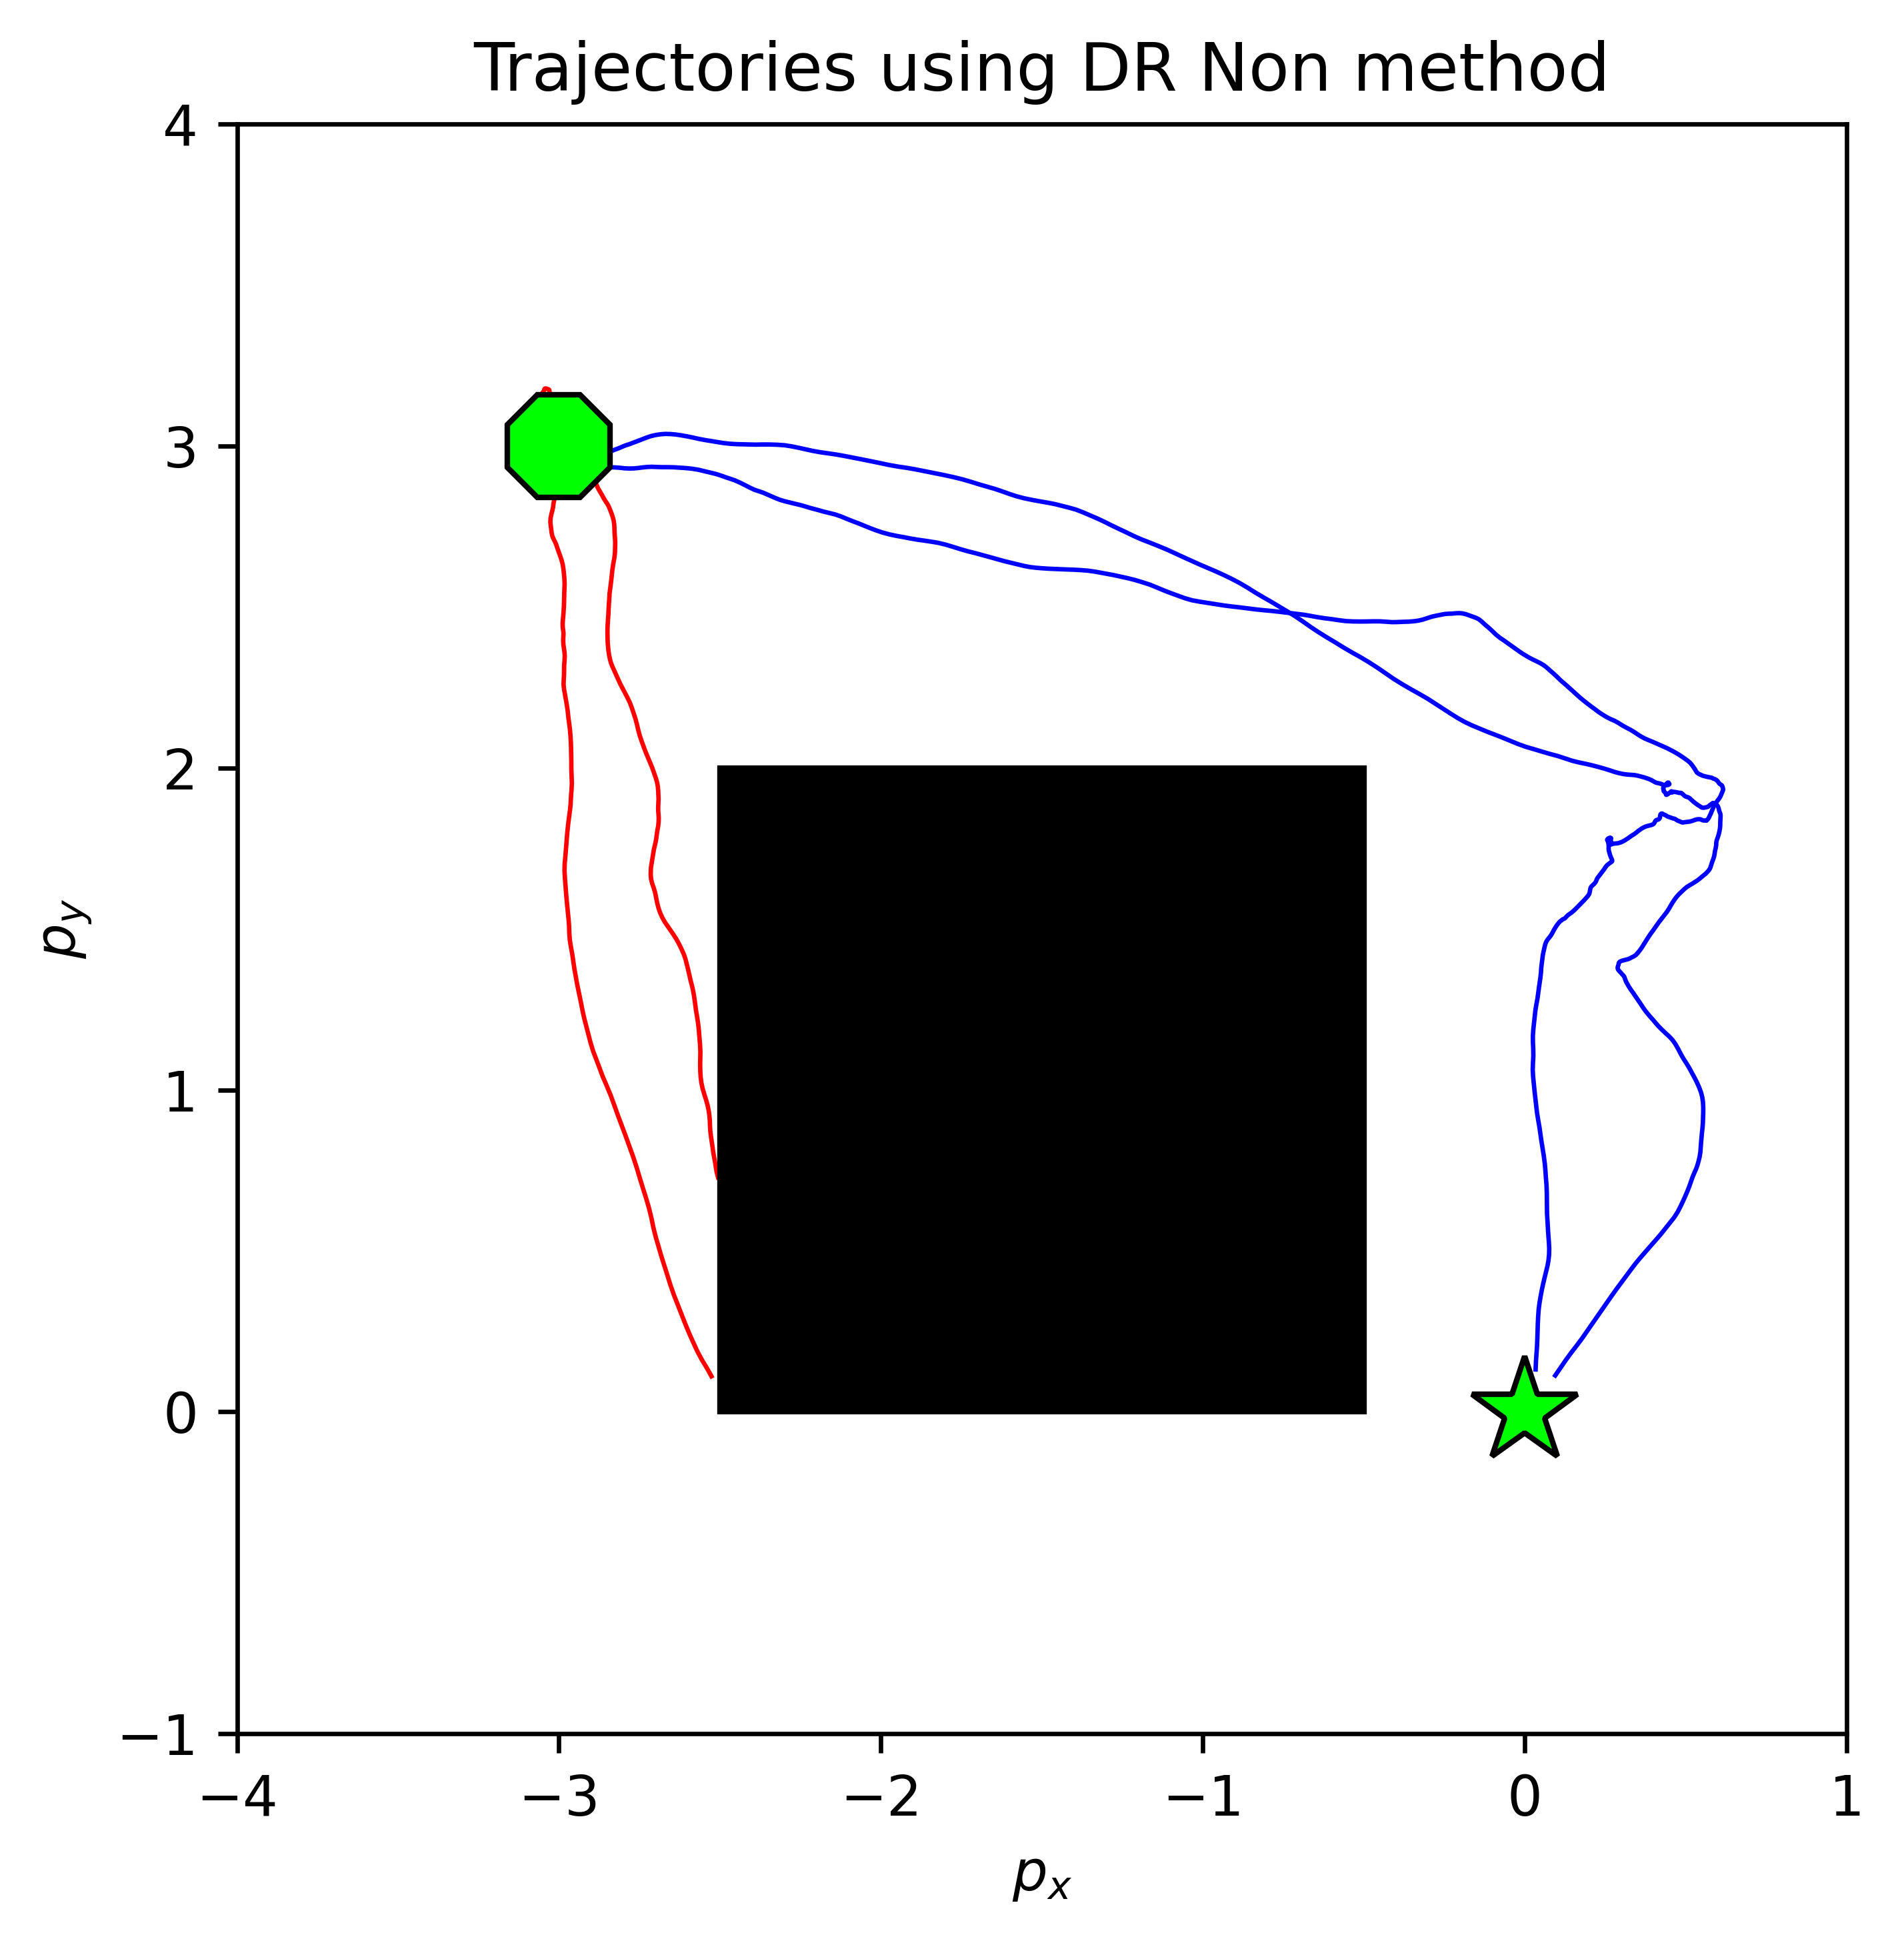

In [ ]:
# Final Vis and Log Save
fig, ax = setup_plot()
plot_initial_and_goal_states(ax, x_init, x_goal)
plot_obstacles(ax, obstacle_positions, obstacle_radius)
plot_trajectories(ax, x_hists, success_index, fail_index)
ax.set_title(f'Trajectories using {method} method')

# Save the plot with the current time as the filename
filename = os.path.join("./log", f"plot_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.png")
save_plot(fig, filename)

plt.show()
